## Import Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
import glob
import os

## Load the bias applied due to walls only 

In [2]:
n_frames = 191
n_restarts = 4

## checking the bias applied due to walls
data_path = "/scratch/projects/hockygroup/gmh4/projects/gmm_clustering/weighted_gmm/actin_clustering_generate_frames/actin_clustering_generate_frames/prod_continue_310K/every5ps_trr"
wall_bias = []

for i in range(n_frames):
    for j in range(n_restarts):
        file = data_path+"/frame{}/{}/COLVAR".format(i,j+1)
        
        bias = np.sum(np.loadtxt(file, usecols=(-4,-3,-2,-1))[::5,:], axis=1)
        #bias = np.sum(np.loadtxt(file, usecols=(10,11,12,13))[::5,:], axis=1)
        wall_bias.append(bias)

wall_bias = np.concatenate(wall_bias, axis=0)
print(wall_bias.shape)

(153564,)


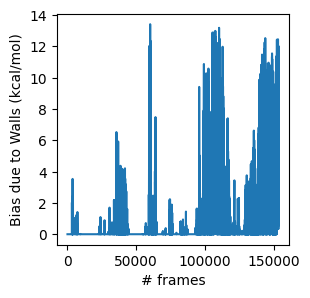

In [3]:
plt.figure(figsize=(3,3))
plt.ylabel("Bias due to Walls (kcal/mol)")
plt.xlabel("# frames")
plt.plot(wall_bias)

## load the trajectories and colvar data

In [4]:
data_path="/scratch/projects/hockygroup/ss12902/posLDA_actin/cluster_opes_data_from_triasha/run_with_v1.6.1/wrapped_trajs_for_actin"
n_frames = 191
n_restarts = 4

In [5]:
trajData = []
colvar_data = []

for i in range(n_frames):
    for j in range(n_restarts):
        traj_file = data_path+"/frame{}/{}/frame{}_{}_positions.npy".format(i,j+1,i,j+1)
        colvar_file = data_path+"/frame{}/{}/frame{}_{}_colvar.txt".format(i,j+1,i,j+1)
        
        traj = np.load(traj_file, allow_pickle=True)
        colvar = np.loadtxt(colvar_file)
        
        trajData.append(traj)
        colvar_data.append(colvar)

trajData = np.concatenate(trajData, axis=0)
colvar_data = np.concatenate(colvar_data, axis=0)

print(trajData.shape)
print(colvar_data.shape)

(153564, 375, 3)
(153564, 4)


In [6]:
kt = 0.616033   # @T=310K in kcal/molK unit
ld1 = colvar_data[:,0]
cleft_dist = colvar_data[:,1]*10.0
dihedral = colvar_data[:,2]*180.0/3.14
opes_bias = colvar_data[:,3]+15.0  # adding the barrier value to bias 

weights = np.exp((opes_bias+wall_bias)/kt)  ## NOTE: here we are adding the wall bias as well
weights /=  np.sum(weights)

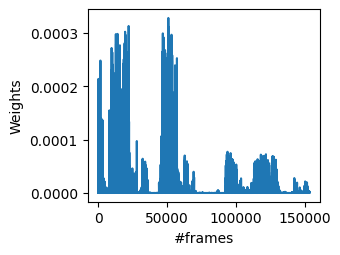

In [7]:
plt.figure(figsize=(3,2.5))
plt.xlabel("#frames")
plt.ylabel("Weights")
plt.plot(weights)

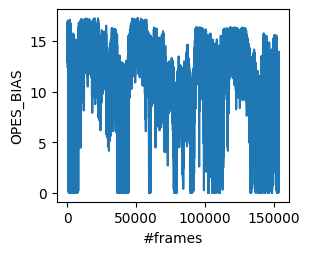

In [8]:
plt.figure(figsize=(3,2.5))
plt.xlabel("#frames")
plt.ylabel("OPES_BIAS")
plt.plot(opes_bias)

## Run the cluster scan ->

In [9]:
# define cluster array 
cluster_array = np.arange(1,7,1).astype(int)
print("#clusters :", cluster_array)

#clusters : [1 2 3 4 5 6]


In [34]:
train, cv = scripts.cross_validate_cluster_scan\
(trajData, 138208, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

Number of frames to train each model: 138208
Number of frames to predict each model: 15356
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1            1004.705          32.018
              1               2               1            1051.310          29.898
              1               2               2            1053.170          28.200
              1               2               3            1047.678          45.876
              1               2               4            1053.089          27.913
              1               2               5            1053.169          26.821
              1               2               6            1052.959          37.756
              1               2               7            1052.

              2               6               3            1116.204          54.898
              2               6               4            1118.319          49.805
              2               6               5            1113.234          82.676
              2               6               6            1125.844          70.328
              2               6               7            1105.043          73.955
              2               6               8            1131.887          53.675
              2               6               9            1112.342          52.000
              2               6              10            1113.082          55.066
              3               1               1            1004.895          31.593
              3               2               1            1035.869          41.225
              3               2               2            1050.286          41.875
              3               2               3            1034.857         

              4               5               9            1109.571          40.178
              4               5              10            1122.393          59.297
              4               6               1            1074.955          54.278
              4               6               2            1121.773          63.420
              4               6               3            1136.302          50.264
              4               6               4            1107.851          63.906
              4               6               5            1086.092          53.925
              4               6               6            1116.280          57.485
              4               6               7            1093.565          55.691
              4               6               8            1113.647          78.302
              4               6               9            1109.891          73.021
              4               6              10            1120.134         

In [ ]:
# write to data files
np.savetxt("train_all_data_copy_testing.dat", np.column_stack((cluster_array, train)))
np.savetxt("cv_all_data_copy_testing.dat", np.column_stack((cluster_array, cv)))

In [10]:
train = np.loadtxt("train_all_data_copy_testing.dat")[:,1:]
cv = np.loadtxt("cv_all_data_copy_testing.dat")[:,1:]

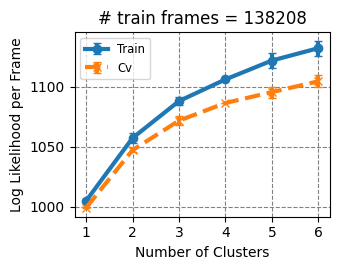

In [11]:
# create figure
plt.figure(figsize=(3.5,2.8), dpi= 100, facecolor='w', edgecolor='k')

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

plt.errorbar(cluster_array,train_mean, train_std, fmt='-o', lw=3, capsize=3, label="Train")

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

plt.errorbar(cluster_array, cv_mean, cv_std, fmt='--x', lw=3, capsize=3, label="Cv")

plt.grid(which='major', axis='both', color='#808080', linestyle='--')

plt.ylabel("Log Likelihood per Frame")
plt.title("# train frames = 138208")
plt.xlabel("Number of Clusters")
plt.tick_params(axis='both')
plt.legend(fontsize="small")
plt.tight_layout()

## fit with 5 Clusters -->

In [27]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 5, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

Number of training frames: 153564
Number of clusters: 5
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1            1105.189          49.531
       2            1106.203          48.628
       3            1109.719          61.153
       4            1096.517          46.707
       5            1110.207          66.382
       6            1114.182          50.853
       7            1090.004          71.054
       8            1104.082          66.604
       9            1078.168          66.680
      10            1083.679          65.696
      11            1087.291          55.932
      12            1103.836          60.194
      13            1091.659          66.881
      14            1113.844          60.662
      15            1107.382          60.997
      16            1104.469          51.849
      17            1080.429          62.071
      18            1105.505          47.680
      19       

In [ ]:
with open("wsgmm_5state_all_data_copy_testing.pickle", 'wb') as f:
    pickle.dump(wsgmm, f)

In [12]:
with open("wsgmm_5state_all_data_copy_testing.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

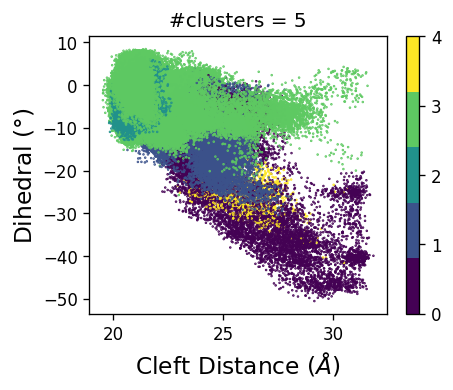

In [13]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("Cleft Distance ($\\AA$)", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(cleft_dist, dihedral, c=wsgmm5.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

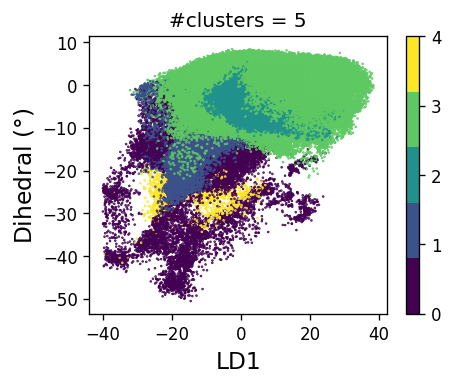

In [14]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap("viridis", len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("LD1", fontsize=14)
plt.ylabel("Dihedral ($\\degree$)", fontsize=14)
plt.scatter(ld1, dihedral, c=wsgmm5.cluster_ids, marker=".", cmap=custom_cmap, s=1.0)
cbar = plt.colorbar(ticks=color_values)

### calculate the centers of each cluster

In [15]:
cluster_indx = []
for i in range(wsgmm5.n_clusters):
    indx = [x[0] for x in np.argwhere(wsgmm5.cluster_ids == i)]
    cluster_indx.append(indx)
    print(len(indx))

avg_dihedral = [np.mean(dihedral[cluster_indx[i]]) for i in range(wsgmm5.n_clusters)]
avg_cleft_dist = [np.mean(cleft_dist[cluster_indx[i]]) for i in range(wsgmm5.n_clusters)]

27355
11470
24468
87551
2720


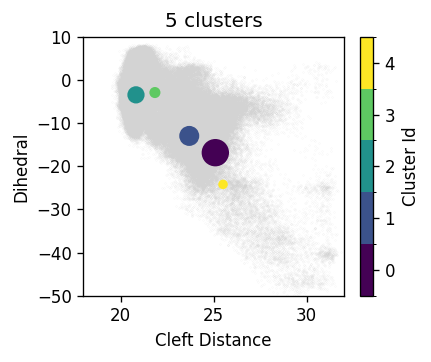

In [16]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

plt.figure(figsize=(3.5,2.8), dpi=120)
plt.title("5 clusters")
plt.xlabel("Cleft Distance")
plt.ylabel("Dihedral")
plt.xlim(18,32)
plt.ylim(-50,10)
plt.scatter(cleft_dist, dihedral, marker='.', s=0.01, color="lightgray")
plt.scatter(avg_cleft_dist, avg_dihedral, marker='o', c=np.arange(wsgmm5.n_clusters), s=wsgmm5.weights*500, cmap=cmap, norm=norm)
cbar = plt.colorbar(ticks=np.arange(0.5, wsgmm5.n_clusters, 1))
cbar.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar.set_label("Cluster Id")

### get the 2D FES from restarted data (using weights)

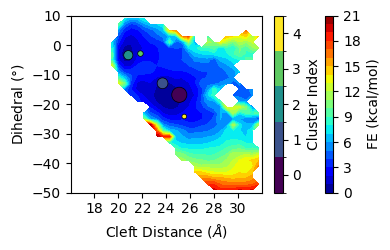

In [17]:
from matplotlib.colors import ListedColormap, BoundaryNorm
kt = 0.616033   # @T=310K in kcal/molK unit

cmap = plt.get_cmap("viridis", wsgmm5.n_clusters)
norm = BoundaryNorm(np.arange(wsgmm5.n_clusters+1), cmap.N)

# get the FE
hist, xedges, yedges = np.histogram2d(cleft_dist, dihedral, bins=[30,30], range=[[16,32],[-50,10]], density=True, weights=np.exp((opes_bias+wall_bias)/kt))
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

fe_rst_data = -kt*np.log(hist)
fe_rst_data -= fe_rst_data.min()

xx,yy = np.meshgrid(xbins, ybins)
plt.figure(figsize=(4,2.6), dpi=100)
plt.xticks([18,20,22,24,26,28,30])
plt.xlim(16,32)
plt.ylim(-50,10)
plt.xlabel("Cleft Distance ($\\AA$)")
plt.ylabel("Dihedral ($\\degree$)")

im1 = plt.contourf(xx, yy, fe_rst_data.T, cmap="jet", levels=20)
cbar_1 = plt.colorbar(im1)
cbar_1.set_label("FE (kcal/mol)")

im2 = plt.scatter(avg_cleft_dist, avg_dihedral, c=np.arange(wsgmm5.n_clusters), cmap=cmap, norm=norm, marker="o", s=wsgmm5.weights*250.0, edgecolor="k", linewidth=0.5)
cbar_2 = plt.colorbar(im2)
cbar_2.set_ticks(np.arange(0.5, wsgmm5.n_clusters,1))
cbar_2.set_ticklabels(np.arange(wsgmm5.n_clusters))
cbar_2.set_label("Cluster Index")

plt.tight_layout()

# save FE data 
np.save("fe_rst_data.npy", fe_rst_data, allow_pickle=True)

## checking if each short trajectory is mostly in one particular state !

In [ ]:
n_samples = 201
lines = []
for i in range(n_frames*n_restarts):
    arr  = np.array(np.unique(wsgmm4.cluster_ids[i*n_samples:(i+1)*n_samples:]), dtype=str)
    line = "%d"%len(arr)+" "*3+",".join(arr)
    lines.append(line)
    print(i, line)

In [ ]:
fo = open("index_list.txt", "w")
c = 0
fo.write("#!FIELDS frame rst n_states states\n")
for i in range(n_frames):
    for j in range(n_restarts):
        fo.write("%d   %d"%(i,j+1)+" "*3+lines[c]+"\n")
        c += 1
fo.close()

## saving the first frame from each short trajectory!

In [18]:
def sort_files(item):
    x1 = int(item.split("/")[-3][5::])
    x2 = int(item.split("/")[-2])
    return x1,x2

def sort_pdb(item):
    x = int(item.split(".")[0].split("_")[-1])
    return x 

In [ ]:
loc_traj_files = "/scratch/projects/hockygroup/gmh4/projects/gmm_clustering/weighted_gmm/actin_clustering_generate_frames/prod_continue_310K/every5ps_trr"
trr_files = glob.glob(loc_traj_files+"/frame*/*/*.trr")
trr_files_sorted = np.array(sorted(trr_files, key=sort_files))
print(len(trr_files_sorted))
#c = 0
#for file in trr_files_sorted:
#    print(c, "/".join(file.split("/")[-3::]))
#    c += 1

In [ ]:
prmtopFileName =  "../run_with_1us_data/actin-gatpu_ionized_npt_20ns_every50ps-g5.1.4_5mus.tpr"
for i in range(len(trr_files_sorted)):
    print(i)
    coord = md.Universe(prmtopFileName, trr_files_sorted[i])
    protein = coord.select_atoms("resid 1 to 375")
    
    # wrap the traj 
    transforms = [trans.unwrap(protein), trans.center_in_box(protein, center="geometry")]
    coord.trajectory.add_transformations(*transforms)
    
    # save the pdb file
    with md.Writer('first_frame_pdb_files/first_frame_traj_{}.pdb'.format(i), protein.n_atoms) as pdb:
        pdb.write(protein)

## check the RMSF fluctuations for 5 clusters

In [19]:
colors_list = ["#440154FF", "#404788FF", "#1F968BFF", "#73D055FF", "#FDE725FF"]
print("colors_list :", colors_list)

colors_list : ['#440154FF', '#404788FF', '#1F968BFF', '#73D055FF', '#FDE725FF']


In [20]:
def pseudo_inv(mat,remove):
    # it calculates the pseudo inverse of a singular matrix
    e, v = np.linalg.eigh(mat)
    e[remove:] = 1/e[remove:]
    e[:remove] = 0.00
    return np.dot(v,np.dot(np.diag(e),v.T))

(5, 375)


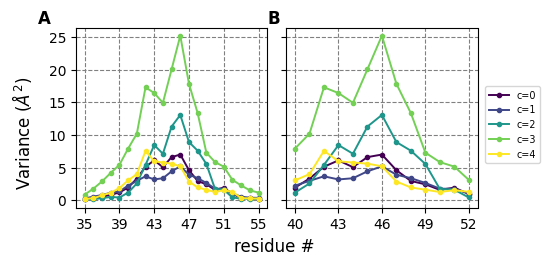

In [62]:
vars_ = np.empty((wsgmm5.n_clusters, trajData.shape[1]))
for i in range(wsgmm5.n_clusters):
    vars_[i,:] = np.diag(pseudo_inv(wsgmm5.precisions[i], 1))
print(vars_.shape)

fig, axs = plt.subplots(1, 2, figsize=(5.5,2.5), sharey=True)
fig.supxlabel("residue #")
fig.supylabel("Variance ($\\AA^2$)")

#0
axs[0].text(-0.2, 1.1, "A", transform=axs[0].transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
axs[0].set_xticks(np.arange(35,56,4))
axs[0].set_yticks(np.arange(0,30,5))
axs[0].grid(which='major', axis='both', color='#808080', linestyle='--')
for i in range(wsgmm5.n_clusters):
    axs[0].plot(np.arange(35,56), vars_[i,34:55:1], ".-", label="c=%d"%i, lw=1.4, color=colors_list[i])
axs[0].legend(fontsize="x-small", ncol=1, bbox_to_anchor=[2.45,0.7])

#1
axs[1].text(-0.1, 1.1, "B", transform=axs[1].transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
axs[1].set_xticks(np.arange(40,53,3))
axs[1].grid(which='major', axis='both', color='#808080', linestyle='--')
for i in range(wsgmm5.n_clusters):
    axs[1].plot(np.arange(40,53), vars_[i,39:52:1], '.-', label="c=%d"%i, lw=1.4, color=colors_list[i])

fig.subplots_adjust(left=0.14, bottom=0.20, wspace=0.1, right=0.87, top=0.92)
plt.savefig("var_actin_d-loop.pdf", format="pdf")

## let's extract the files for 5 clusters ->

In [ ]:
traj_first_frame_labels = wsgmm5.cluster_ids[::201]
print(traj_first_frame_labels.shape)

plt.figure(figsize=(3.5,2.8))
plt.plot(traj_first_frame_labels, '.')

loc_list = []
for i in range(wsgmm5.n_clusters):
    loc = [x[0] for x in np.argwhere(traj_first_frame_labels == i)]
    print(len(loc))
    loc_list.append(loc)

pdb_files_sorted = np.array(sorted(glob.glob("first_frame_pdb_files/*.pdb"), key=sort_pdb))

for i in range(wsgmm5.n_clusters):
    files = pdb_files_sorted[loc_list[i]]
    dir_ = "c%d_files_5clusters_new_obj"%i
    if not os.path.isfile(dir_):
        os.mkdir(dir_)
        for file in files:
            os.system("cp "+file+" "+dir_)
    else:
        raise(dir_+" already exists! Please check.")